Import Modules

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [30]:
# Load datasets
no_anomaly_df = pd.read_csv("anomaly-free_data.csv")
normal_df = pd.read_csv("combined_alldata.csv")

In [31]:
no_anomaly_df.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
0,08/02/2020 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
1,08/02/2020 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2,08/02/2020 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
3,08/02/2020 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
4,08/02/2020 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


In [32]:
no_anomaly_df.isnull().sum()

datetime               0
Accelerometer1RMS      0
Accelerometer2RMS      0
Current                0
Pressure               0
Temperature            0
Thermocouple           0
Voltage                0
Volume Flow RateRMS    0
dtype: int64

In [33]:
normal_df.isnull().sum()

datetime               0
Accelerometer1RMS      0
Accelerometer2RMS      0
Current                0
Pressure               0
Temperature            0
Thermocouple           0
Voltage                0
Volume Flow RateRMS    0
anomaly                0
changepoint            0
dtype: int64

In [34]:
no_anomaly_df['anomaly'] = 0
no_anomaly_df['changepoint'] = 0
no_anomaly_df.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,08/02/2020 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664,0,0
1,08/02/2020 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338,0,0
2,08/02/2020 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338,0,0
3,08/02/2020 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664,0,0
4,08/02/2020 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000,0,0


In [35]:
normal_df.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,3/1/2020 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0,0
1,3/1/2020 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0,0
2,3/1/2020 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0,0
3,3/1/2020 15:44:09,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0,0
4,3/1/2020 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0,0


In [36]:
# Convert datetime column to datetime type
no_anomaly_df['datetime'] = pd.to_datetime(no_anomaly_df['datetime'], format='%d/%m/%Y %H:%M:%S')
normal_df['datetime'] = pd.to_datetime(normal_df['datetime'], format='%d/%m/%Y %H:%M:%S')

# Extract features from 'datetime'
for df in [no_anomaly_df, normal_df]:
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['second'] = df['datetime'].dt.second

# Drop the original 'datetime' column (optional)
no_anomaly_df = no_anomaly_df.drop(['datetime'], axis=1)
normal_df = normal_df.drop(['datetime'], axis=1)

In [37]:
no_anomaly_df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint,year,month,day,hour,minute,second
0,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664,0,0,2020,2,8,13,30,47
1,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338,0,0,2020,2,8,13,30,48
2,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338,0,0,2020,2,8,13,30,50
3,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664,0,0,2020,2,8,13,30,51
4,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000,0,0,2020,2,8,13,30,52


In [38]:
normal_df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint,year,month,day,hour,minute,second
0,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0,0,2020,1,3,15,44,6
1,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0,0,2020,1,3,15,44,7
2,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0,0,2020,1,3,15,44,8
3,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0,0,2020,1,3,15,44,9
4,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0,0,2020,1,3,15,44,10


In [39]:
# Define the feature columns
feature_columns = ["year", "month", "day", "hour", "minute", "second","Accelerometer1RMS", "Accelerometer2RMS", "Current", "Pressure", "Temperature", "Thermocouple", "Voltage", "Volume Flow RateRMS"]

In [40]:
# Split features and labels for anomaly-free data
X_no_anomaly = no_anomaly_df[feature_columns]

# Split features and labels for normal data
X_normal = normal_df[feature_columns]
y_anomaly = normal_df["anomaly"]
y_changepoint = normal_df["changepoint"]

In [41]:
# Combine the anomaly-free data with the normal data
X = pd.concat([X_no_anomaly, X_normal])
y_anomaly_combined = pd.concat([pd.Series([0]*len(X_no_anomaly)), y_anomaly])  # 0 for no anomaly, 1 for anomaly
y_changepoint_combined = pd.concat([pd.Series([0]*len(X_no_anomaly)), y_changepoint])  # 0 for no changepoint

In [42]:
# Add an extra dimension for LSTM
X = np.expand_dims(X, axis=1)

In [43]:
# For anomaly detection
y_anomaly_combined = pd.concat([pd.Series([0]*len(X_no_anomaly)), y_anomaly]) # 0 for no anomaly, 1 for anomaly
X_train_anomaly, X_test_anomaly, y_train_anomaly, y_test_anomaly = train_test_split(X, y_anomaly_combined, test_size=0.2, random_state=42)

model_anomaly = Sequential()
model_anomaly.add(LSTM(64, activation='relu', input_shape=(1, len(feature_columns))))
model_anomaly.add(Dense(1, activation='sigmoid'))
model_anomaly.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_anomaly.fit(X_train_anomaly, y_train_anomaly, validation_data=(X_test_anomaly, y_test_anomaly), epochs=100, batch_size=32)

Epoch 1/100
1171/1171 [==============================] - 4s 2ms/step - loss: 0.7333 - accuracy: 0.6791 - val_loss: 0.5730 - val_accuracy: 0.7346
Epoch 2/100
1171/1171 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.6942 - val_loss: 0.5783 - val_accuracy: 0.5991
Epoch 3/100
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5512 - accuracy: 0.6992 - val_loss: 0.7072 - val_accuracy: 0.4701
Epoch 4/100
1171/1171 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.7116 - val_loss: 0.5757 - val_accuracy: 0.5581
Epoch 5/100
1171/1171 [==============================] - 2s 2ms/step - loss: 0.5328 - accuracy: 0.7138 - val_loss: 0.4866 - val_accuracy: 0.7561
Epoch 6/100
1171/1171 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7128 - val_loss: 0.4836 - val_accuracy: 0.7584
Epoch 7/100
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5275 - accuracy: 0.7186 - val_loss: 0.6816 - val_ac

In [44]:
# For changepoint detection
y_changepoint_no_anomaly = pd.Series([0]*len(X_no_anomaly))  # 0 for no changepoint
y_changepoint_combined = pd.concat([y_changepoint_no_anomaly, y_changepoint]) 
X_train_changepoint, X_test_changepoint, y_train_changepoint, y_test_changepoint = train_test_split(X, y_changepoint_combined, test_size=0.2, random_state=42)

model_changepoint = Sequential()
model_changepoint.add(LSTM(64, activation='relu', input_shape=(1, len(feature_columns))))
model_changepoint.add(Dense(1, activation='sigmoid'))
model_changepoint.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_changepoint.fit(X_train_changepoint, y_train_changepoint, validation_data=(X_test_changepoint, y_test_changepoint), epochs=10, batch_size=32)

Epoch 1/10
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0442 - accuracy: 0.9972 - val_loss: 0.0246 - val_accuracy: 0.9971
Epoch 2/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0256 - accuracy: 0.9973 - val_loss: 0.0281 - val_accuracy: 0.9971
Epoch 3/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0279 - accuracy: 0.9973 - val_loss: 0.0262 - val_accuracy: 0.9971
Epoch 4/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0253 - accuracy: 0.9973 - val_loss: 0.0193 - val_accuracy: 0.9971
Epoch 5/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0256 - accuracy: 0.9973 - val_loss: 0.0200 - val_accuracy: 0.9971
Epoch 6/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0249 - accuracy: 0.9973 - val_loss: 0.0215 - val_accuracy: 0.9971
Epoch 7/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0237 - accuracy: 0.9973 - val_loss: 0.0195 - val_accuracy:

In [45]:
# Predict on the test data
y_pred_anomaly = (model_anomaly.predict(X_test_anomaly) > 0.5).astype("int32")
y_pred_changepoint = (model_changepoint.predict(X_test_changepoint) > 0.5).astype("int32")

293/293 [==============================] - 0s 1ms/step


In [46]:
# Print the classification report
print("Anomaly detection classification report:")
print(classification_report(y_test_anomaly, y_pred_anomaly))

Anomaly detection classification report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      6866
           1       0.89      0.55      0.68      2496

    accuracy                           0.86      9362
   macro avg       0.87      0.76      0.80      9362
weighted avg       0.87      0.86      0.85      9362



In [47]:
print("Changepoint detection classification report:")
print(classification_report(y_test_changepoint, y_pred_changepoint))

Changepoint detection classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9335
           1       0.00      0.00      0.00        27

    accuracy                           1.00      9362
   macro avg       0.50      0.50      0.50      9362
weighted avg       0.99      1.00      1.00      9362



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


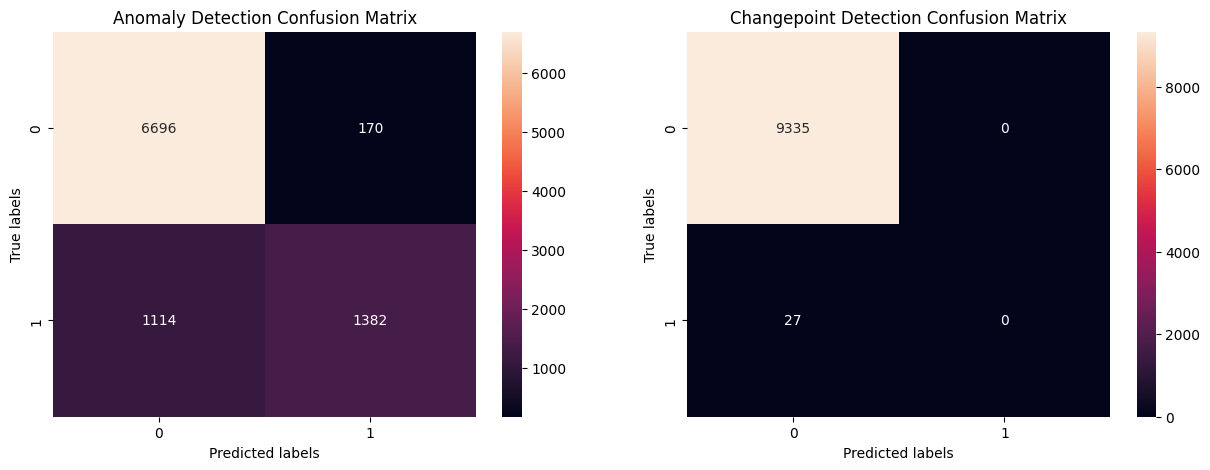

In [48]:
# Plot the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(confusion_matrix(y_test_anomaly, y_pred_anomaly), annot=True, ax=ax[0], fmt='d')
ax[0].set_title('Anomaly Detection Confusion Matrix')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')

sns.heatmap(confusion_matrix(y_test_changepoint, y_pred_changepoint), annot=True, ax=ax[1], fmt='d')
ax[1].set_title('Changepoint Detection Confusion Matrix')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')

plt.show()

In [49]:
# Predict probabilities for the test data
y_pred_probs_anomaly = model_anomaly.predict(X_test_anomaly)
y_pred_probs_changepoint = model_changepoint.predict(X_test_changepoint)

293/293 [==============================] - 0s 1ms/step


In [50]:
# Check if there are any NaN values in your test data and prediction.
print("NaN in y_test_anomaly:", y_test_anomaly.isnull().any())
print("NaN in y_pred_probs_anomaly:", np.isnan(y_pred_probs_anomaly).any())
print("NaN in y_test_changepoint:", y_test_changepoint.isnull().any())
print("NaN in y_pred_probs_changepoint:", np.isnan(y_pred_probs_changepoint).any())

NaN in y_test_anomaly: False
NaN in y_pred_probs_anomaly: False
NaN in y_test_changepoint: False
NaN in y_pred_probs_changepoint: False


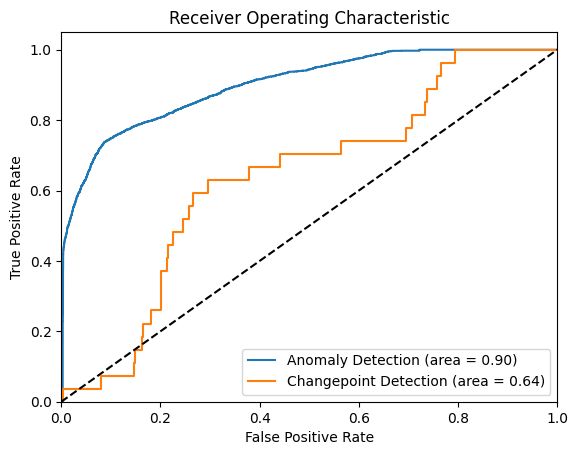

In [51]:
# Compute ROC curve and ROC AUC for each class
fpr_anomaly, tpr_anomaly, _ = roc_curve(y_test_anomaly, y_pred_probs_anomaly)
roc_auc_anomaly = roc_auc_score(y_test_anomaly, y_pred_probs_anomaly)

fpr_changepoint, tpr_changepoint, _ = roc_curve(y_test_changepoint, y_pred_probs_changepoint)
roc_auc_changepoint = roc_auc_score(y_test_changepoint, y_pred_probs_changepoint)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_anomaly, tpr_anomaly, label='Anomaly Detection (area = %0.2f)' % roc_auc_anomaly)
plt.plot(fpr_changepoint, tpr_changepoint, label='Changepoint Detection (area = %0.2f)' % roc_auc_changepoint)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [52]:
history_anomaly = model_anomaly.fit(X_train_anomaly, y_train_anomaly, validation_data=(X_test_anomaly, y_test_anomaly), epochs=10, batch_size=32)

history_changepoint = model_changepoint.fit(X_train_changepoint, y_train_changepoint, validation_data=(X_test_changepoint, y_test_changepoint), epochs=10, batch_size=32)

Epoch 1/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.4113 - accuracy: 0.8300 - val_loss: 0.4413 - val_accuracy: 0.8005
Epoch 2/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.4067 - accuracy: 0.8354 - val_loss: 0.3963 - val_accuracy: 0.8361
Epoch 3/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.4071 - accuracy: 0.8362 - val_loss: 0.4014 - val_accuracy: 0.8399
Epoch 4/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.4089 - accuracy: 0.8328 - val_loss: 0.3901 - val_accuracy: 0.8735
Epoch 5/10
1171/1171 [==============================] - 2s 2ms/step - loss: 0.4062 - accuracy: 0.8356 - val_loss: 0.3937 - val_accuracy: 0.8229
Epoch 6/10
1171/1171 [==============================] - 3s 2ms/step - loss: 0.4031 - accuracy: 0.8382 - val_loss: 0.4056 - val_accuracy: 0.8452
Epoch 7/10
1171/1171 [==============================] - 3s 2ms/step - loss: 0.4021 - accuracy: 0.8385 - val_loss: 0.4060 - val_accuracy:

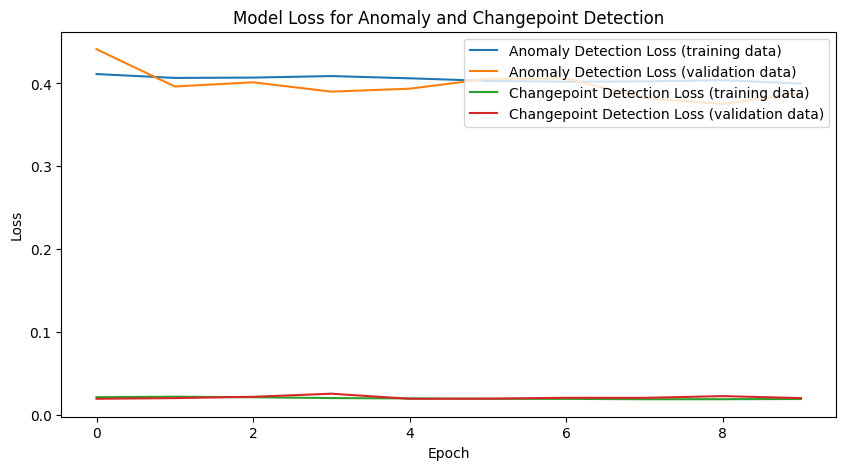

In [53]:
# Plotting loss
plt.figure(figsize=(10,5))
plt.plot(history_anomaly.history['loss'], label='Anomaly Detection Loss (training data)')
plt.plot(history_anomaly.history['val_loss'], label='Anomaly Detection Loss (validation data)')
plt.plot(history_changepoint.history['loss'], label='Changepoint Detection Loss (training data)')
plt.plot(history_changepoint.history['val_loss'], label='Changepoint Detection Loss (validation data)')
plt.title('Model Loss for Anomaly and Changepoint Detection')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

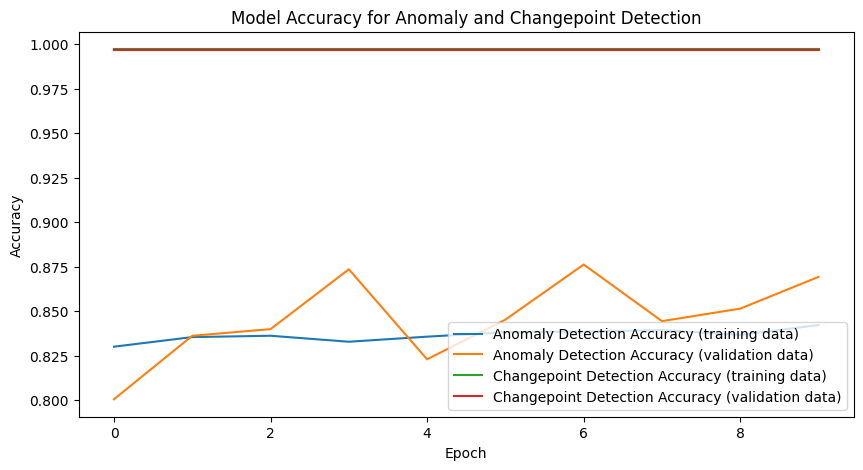

In [54]:
# Plotting accuracy
plt.figure(figsize=(10,5))
plt.plot(history_anomaly.history['accuracy'], label='Anomaly Detection Accuracy (training data)')
plt.plot(history_anomaly.history['val_accuracy'], label='Anomaly Detection Accuracy (validation data)')
plt.plot(history_changepoint.history['accuracy'], label='Changepoint Detection Accuracy (training data)')
plt.plot(history_changepoint.history['val_accuracy'], label='Changepoint Detection Accuracy (validation data)')
plt.title('Model Accuracy for Anomaly and Changepoint Detection')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()